This notebook demonstrates an end-to-end pipeline for topological feature extraction from medical images (PneumoniaMNIST) using Cubical Persistent Homology (PH).
We compute persistence diagrams, vectorize them via persistence images, and use Logistic Regression, XGBoost, Random Forest classifier for pneumonia diagnosis.
We also produce methods-figures for persistence diagrams and persistence images.

In [70]:
!pip install medmnist giotto-tda scikit-learn matplotlib seaborn gudhi

In [107]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import medmnist
import cv2
import skimage
import shap
import pandas as pd
import xgboost as xgb

import gudhi as gd
import seaborn as sns

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split

from gtda.homology import CubicalPersistence
from gtda.diagrams import PersistenceImage
from gtda.diagrams import BettiCurve
from gtda.plotting import plot_diagram
from medmnist import PneumoniaMNIST

from skimage import feature
import skimage.transform as tf

# Set random seed
#np.random.seed(42)

In [72]:
# Load PneumoniaMNIST dataset (2D grayscale chest X-ray images)

#data = PneumoniaMNIST(split='train', download=True, size=64)
#x_train, y_train = data.imgs, data.labels

#data_test = PneumoniaMNIST(split='test', download=True, size=64)
#x_test, y_test = data_test.imgs, data_test.labels

#data_val = PneumoniaMNIST(split='val', download=True, size=64)
#x_val, y_val = data_val.imgs, data_val.labels

#print("Train:", x_train.shape, "Test:", x_test.shape, "Val:", x_val.shape)

# Load PneumoniaMNIST dataset (2D grayscale chest X-ray images)

data = PneumoniaMNIST(split='train', download=True, size=64)
x_train, y_train = data.imgs, data.labels


# 80:20 split
X_train, X_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (3766, 64, 64) Test: (942, 64, 64)


In [73]:
# Flatten into shape (n_samples, height, width)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3766, 64, 64) (3766, 1)
(942, 64, 64) (942, 1)


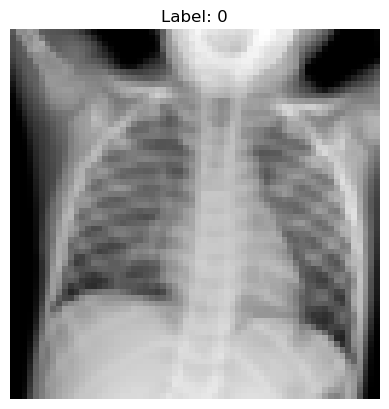

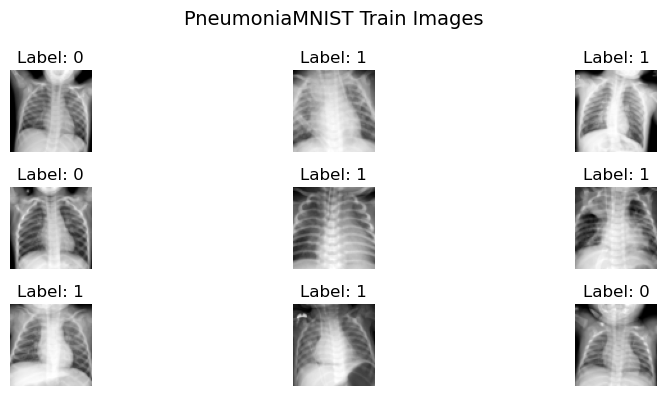

In [74]:
# Choose a single chest X-Ray image sample from the train set
sample = X_train[0]

#Plot the sample image

plt.imshow(sample, cmap='gray')
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

#Plot more samples from the train set

plt.figure(figsize=(10, 4))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i][0]}")
    plt.axis('off')
plt.suptitle("PneumoniaMNIST Train Images", fontsize=14)
plt.tight_layout()
plt.show()

In [75]:
# Store Cubical Persistence

cp = CubicalPersistence(homology_dimensions=[0, 1], coeff=3, n_jobs=-1)
cp0 = CubicalPersistence(homology_dimensions=[0], coeff=3, n_jobs=-1)
cp1 = CubicalPersistence(homology_dimensions=[1], coeff=3, n_jobs=-1)

In [76]:
# Persistent Diagrams

diagrams_train = cp.fit_transform(X_train)
diagram0_train = cp0.fit_transform(X_train)
diagram1_train = cp1.fit_transform(X_train)

diagrams_test = cp.fit_transform(X_test)

diagram_sample = cp.fit_transform(sample[None, :, :])

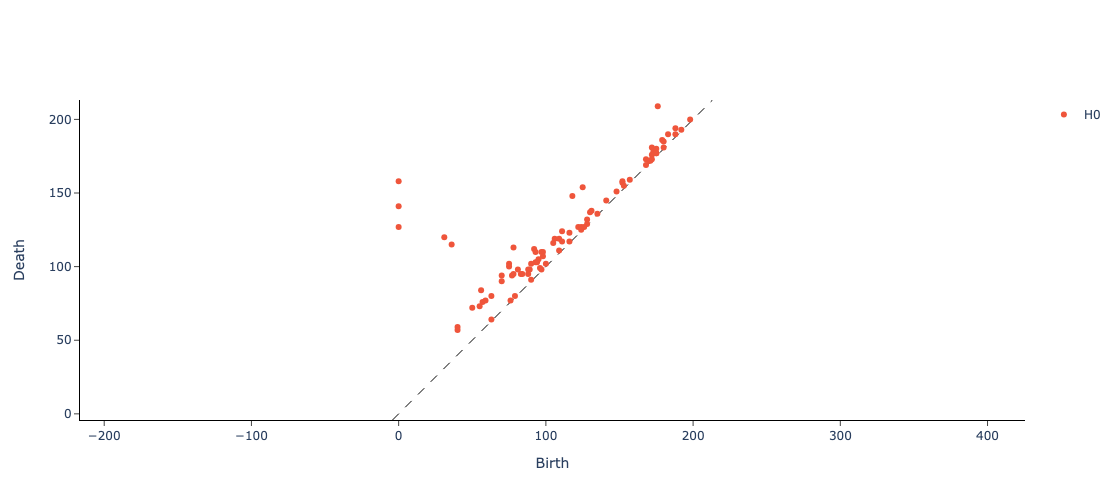

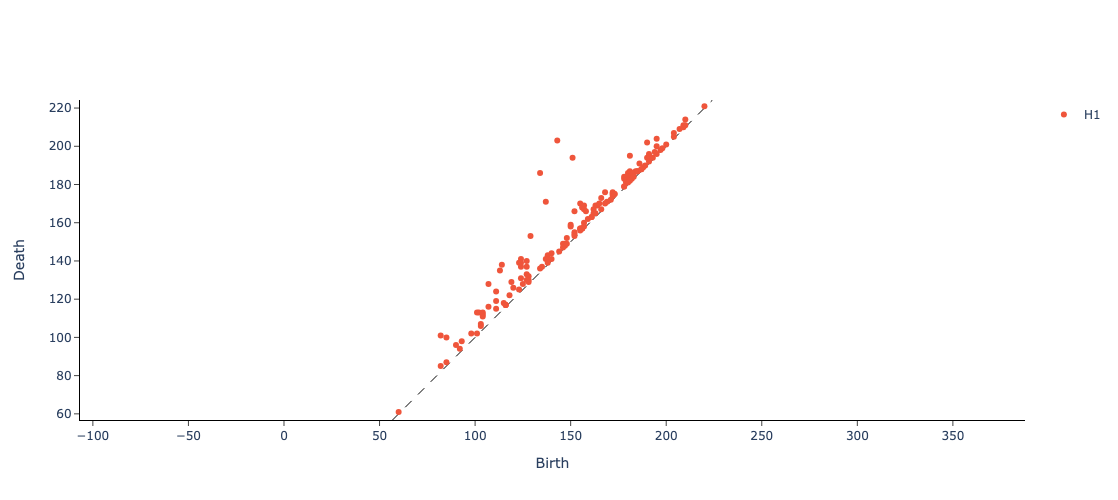

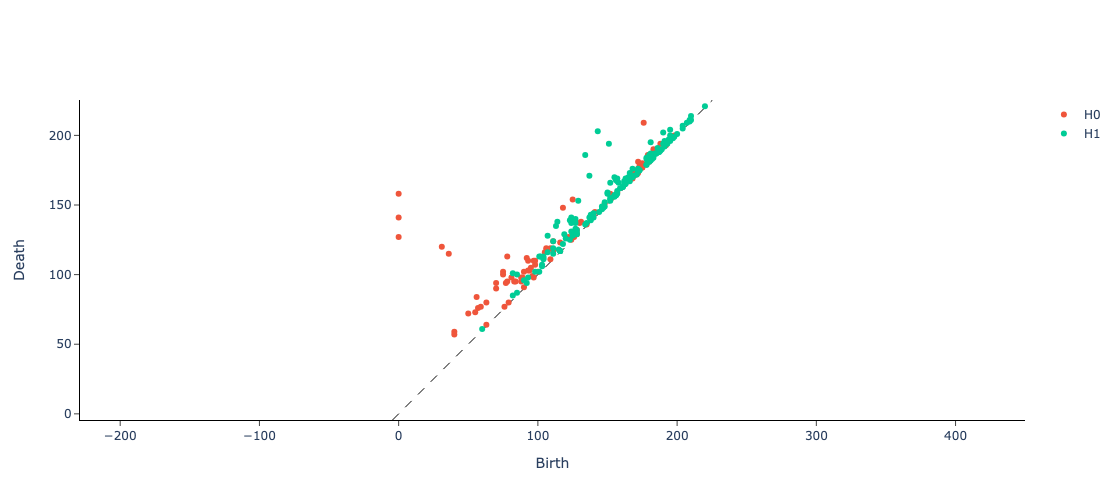

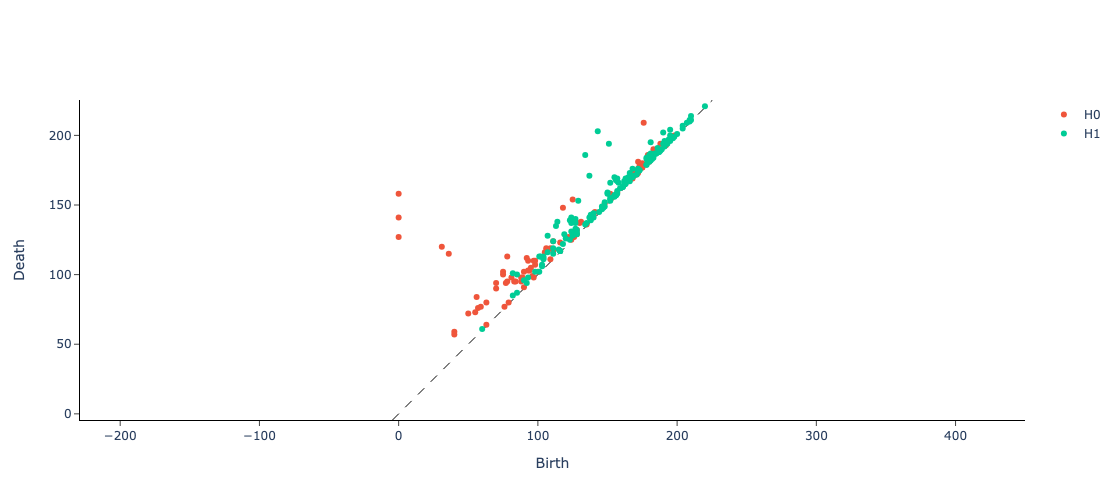

In [77]:
fig1 = plot_diagram(diagram0_train[0]) 
fig1.show()

fig2 = plot_diagram(diagram1_train[0])
fig2.show()

fig3 = plot_diagram(diagrams_train[0])
fig3.show()

fig4 = plot_diagram(diagram_sample[0])
fig4.show()

In [78]:
bc = BettiCurve(n_bins = 50)

betti0_curves = bc.fit_transform(diagram0_train)
betti1_curves = bc.fit_transform(diagram1_train)
print(betti0_curves.shape)  
print(betti1_curves.shape) 

betti_curves = bc.fit_transform(diagrams_train)
print(betti_curves.shape)

betti_curve_sample = bc.fit_transform(diagram_sample)
print(betti_curve_sample.shape)

betti_curve_test =bc.fit_transform(diagrams_test)
print(betti_curve_test.shape)

#betti_curve_val = bc.fit_transform(diagrams_val)
#print(betti_curve_val.shape)

(3766, 1, 50)
(3766, 1, 50)
(3766, 2, 50)
(1, 2, 50)
(942, 2, 50)


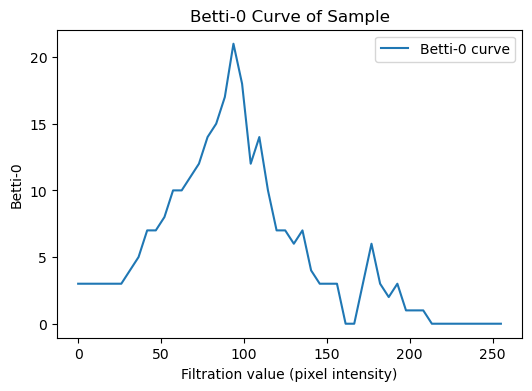

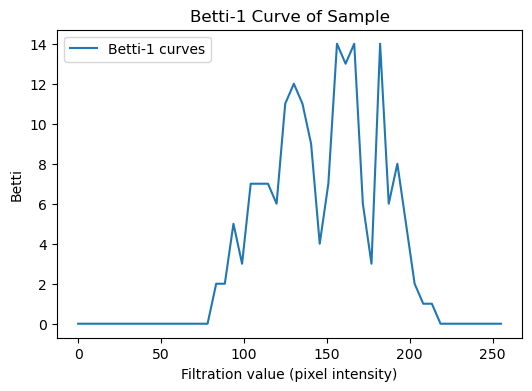

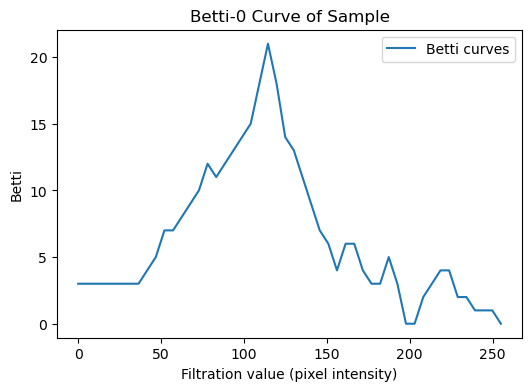

In [79]:
betti0 = betti0_curves[0, 0, :]   # first sample, H0 dimension
betti1 = betti_curves[0, 1, :]
betti0_sample = betti_curve_sample[0, 0, :]

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti0)), betti0, label="Betti-0 curve")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti-0")
plt.title("Betti-0 Curve of Sample")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti1)), betti1, label="Betti-1 curves")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti")
plt.title("Betti-1 Curve of Sample")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti0_sample)), betti0_sample, label="Betti curves")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti")
plt.title("Betti-0 Curve of Sample")
plt.legend()
plt.show()

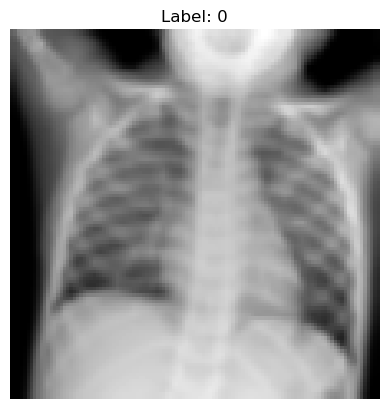

In [80]:

# Trying to preprocess the sample image hoping to extract more features (Betti and PI)

sample_up = tf.resize(sample, (112,112))


#Plot the upscaled sample image

plt.imshow(sample_up, cmap='gray')
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

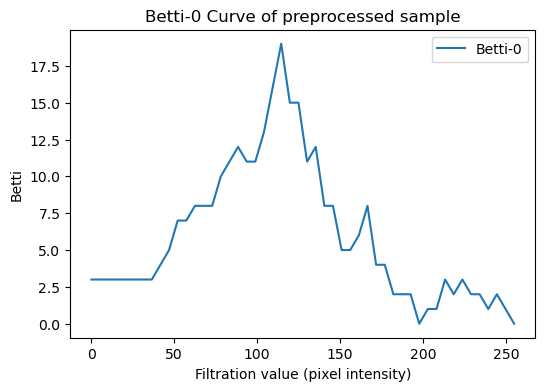

In [81]:
# Compute PD for preprocessed sample image
diagram_sample_up = cp.fit_transform(sample_up[None, :, :])

# Fit and transform PD to Betti curve
betti_curve_sample_up = bc.fit_transform(diagram_sample_up)

#Betti-0
betti0_sample_up = betti_curve_sample_up[0, 0, :]

# Plot Betti-0 curve for preprocessed sample
plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti0_sample_up)), betti0_sample_up, label="Betti-0")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti")
plt.title("Betti-0 Curve of preprocessed sample")
plt.legend()
plt.show()

PI feature shape: (3766, 2, 20, 20)
PI feature shape: (942, 2, 20, 20)
Flattened Train shape: (3766, 800)
Flattened Test shape: (942, 800)
Shape of one sample: (2, 20, 20)


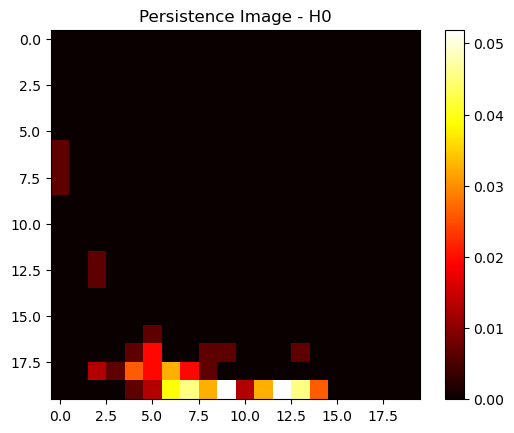

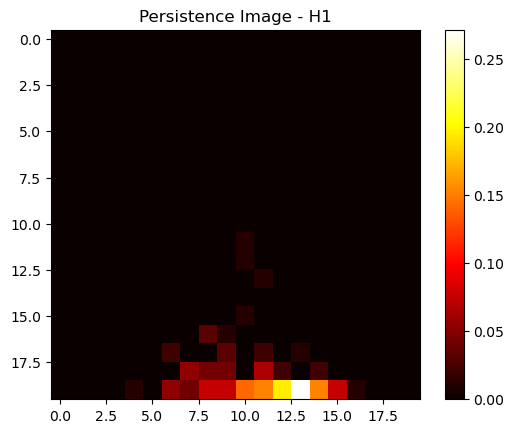

In [82]:
# Convert diagrams into persistence images

# Initialize Persistence Image Transformer
pi = PersistenceImage(n_bins=20, sigma=0.8, n_jobs=-1) # Change sigma later  

# Fit and transform PDs into PIs (returns vector for each image)
x_train_pi = pi.fit_transform(diagrams_train)
x_test_pi = pi.fit_transform(diagrams_test)

print("PI feature shape:", x_train_pi.shape) # (n_samples, hom_dim, n_bins, n_bins)
print("PI feature shape:", x_test_pi.shape)

# Flatten PI images for ML integration
x_train_flat = x_train_pi.reshape(len(x_train_pi), -1)
x_test_flat = x_test_pi.reshape(len(x_test_pi), -1)

print("Flattened Train shape:", x_train_flat.shape) # (n_samples, 2*20*20)
print("Flattened Test shape:", x_test_flat.shape)

# Visualize one sample (H0 and H1 PIs)

pi_sample = x_train_pi[0]

print("Shape of one sample:", x_train_pi[0].shape) 

# H0
plt.imshow(pi_sample[0], cmap="hot")
plt.colorbar()
plt.title("Persistence Image - H0")
plt.show()

# H1
plt.imshow(pi_sample[1], cmap="hot")
plt.colorbar()
plt.title("Persistence Image - H1")
plt.show()

In [83]:
print(betti_curves.shape)
print(y_train.shape)

y_train_m = y_train.ravel() # (n_samples,)
y_test_m = y_test.ravel()


print(X_train.shape)
print(y_train_m.shape)
print(y_test_m.shape)


(3766, 2, 50)
(3766, 1)
(3766, 64, 64)
(3766,)
(942,)


In [84]:


betti0_curves = betti_curves[:, 0, :]  # H0
betti1_curves = betti_curves[:, 1, :]  # H1

betti0_normal = betti0_curves[y_train_m==0]
betti0_pneumonia = betti0_curves[y_train_m==1]
betti1_normal = betti1_curves[y_train_m==0]
betti1_pneumonia = betti1_curves[y_train_m==1]


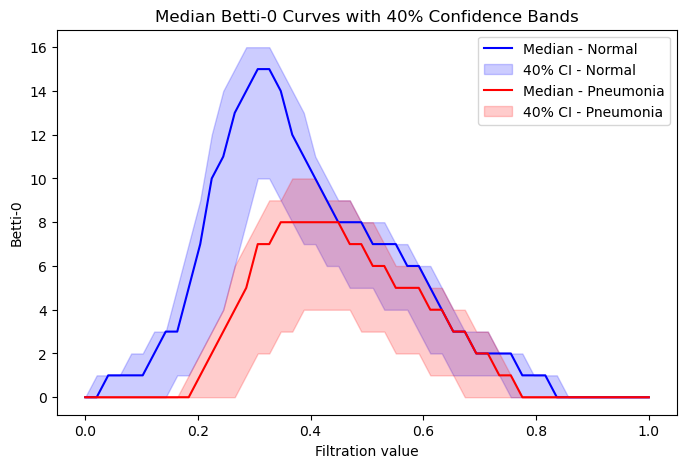

In [85]:
# Function to compute median and 40% confidence band
def median_and_band(curves, lower=20, upper=60):  # 40% band
    median = np.median(curves, axis=0)
    lb = np.percentile(curves, lower, axis=0)
    ub = np.percentile(curves, upper, axis=0)
    return median, lb, ub

# Compute median + 40% band for each class (H0 only)
median0_n, lb0_n, ub0_n = median_and_band(betti0_normal)
median0_p, lb0_p, ub0_p = median_and_band(betti0_pneumonia)

bins = np.linspace(0, 1, betti0_normal.shape[1])  # Filtration axis

plt.figure(figsize=(8,5))

# Plot Normal
plt.plot(bins, median0_n, color="blue", label="Median - Normal")
plt.fill_between(bins, lb0_n, ub0_n, color="blue", alpha=0.2, label="40% CI - Normal")

# Plot Pneumonia
plt.plot(bins, median0_p, color="red", label="Median - Pneumonia")
plt.fill_between(bins, lb0_p, ub0_p, color="red", alpha=0.2, label="40% CI - Pneumonia")

plt.xlabel("Filtration value")
plt.ylabel("Betti-0")
plt.title("Median Betti-0 Curves with 40% Confidence Bands")
plt.legend(loc="upper right")
plt.show()

In [86]:
print(np.min(X_train), np.max(X_train))

0 255


In [87]:
#x_train_scaled = x_train / np.max(x_train) * 100
x_train_scaled = (X_train - X_train.min()) / (X_train.max() - X_train.min()) * 100

In [88]:
from skimage.transform import resize
x_train_up = np.array([resize(img, (128,128)) for img in x_train_scaled])

In [89]:
print(y_train.shape)

(3766, 1)


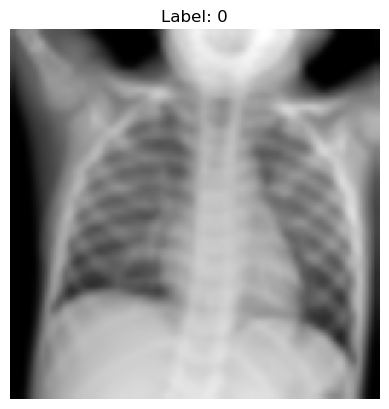

In [90]:
plt.imshow(x_train_up[0], cmap='gray')
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()


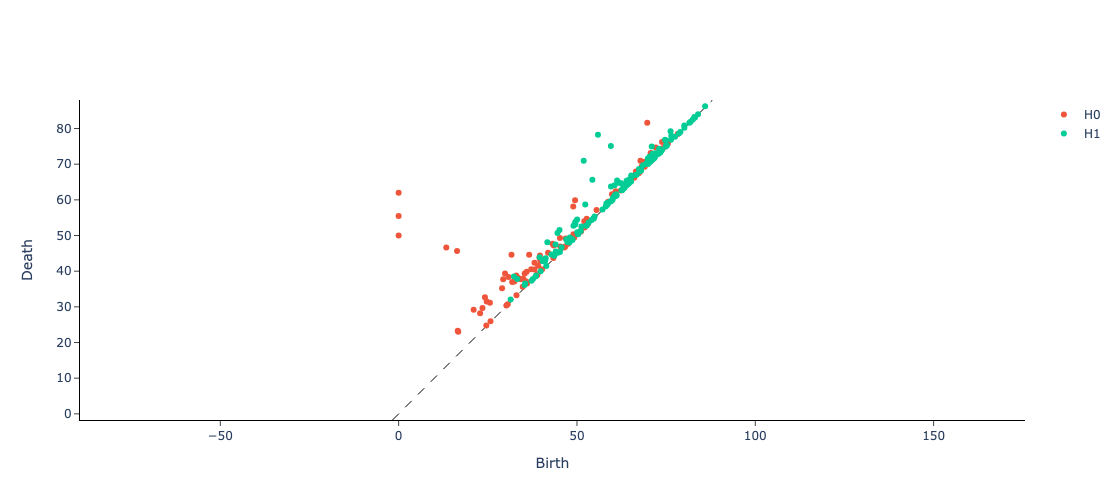

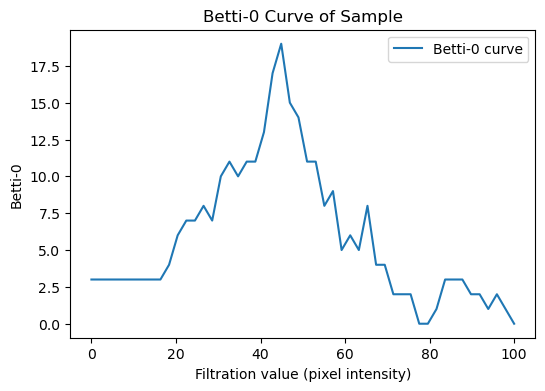

In [91]:
sample = x_train_up[0]
diagram_sample_up = cp.fit_transform(sample[None, :, :])
fig = plot_diagram(diagram_sample_up[0]) 
fig.show()
betti_sample_up = bc.fit_transform(diagram_sample_up)
betti0_up = betti_sample_up[0, 0, :]

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 100, len(betti0_up)), betti0_up, label="Betti-0 curve")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti-0")
plt.title("Betti-0 Curve of Sample")
plt.legend()
plt.show()

In [92]:
#### Training Classification Models #####

In [93]:
# Initializer

y_train_m = y_train.ravel() # (n_samples,)
y_test_m = y_test.ravel()


X_train_vec = betti_curves.reshape(betti_curves.shape[0], -1)
X_test_vec = betti_curve_test.reshape(betti_curve_test.shape[0], -1)
print("Flattened train shape:", X_train_vec.shape)
print("Flattened test shape:", X_test_vec.shape)
print("Flattened train label shape:", y_train_m.shape)
print("Flattened test label shape:", y_test_m.shape)


print("Test:", X_test_vec.shape, y_test_m.shape)

print("Train:", X_train_vec.shape, y_train_m.shape)


Flattened train shape: (3766, 100)
Flattened test shape: (942, 100)
Flattened train label shape: (3766,)
Flattened test label shape: (942,)
Test: (942, 100) (942,)
Train: (3766, 100) (3766,)


Accuracy: 0.9002123142250531
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       243
           1       0.92      0.95      0.93       699

    accuracy                           0.90       942
   macro avg       0.88      0.86      0.87       942
weighted avg       0.90      0.90      0.90       942

ROC AUC: 0.963183736908105


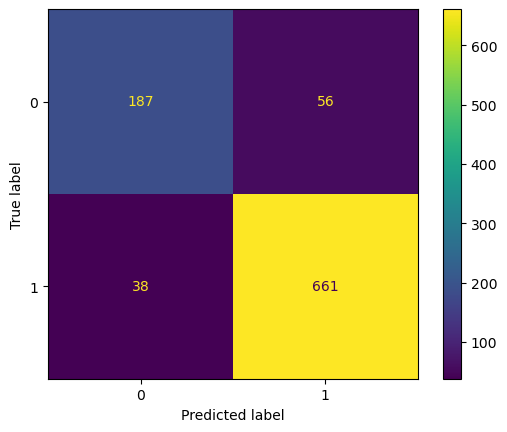

In [94]:
# Train Random Forest model on PneumoniaMNIST dataset 
clf = RandomForestClassifier(random_state=42)

# Fit model
clf.fit(X_train_vec, y_train_m)

# Predict
y_pred_RF = clf.predict(X_test_vec)
y_proba_RF = clf.predict_proba(X_test_vec)[:, 1]

# Evaluate
print("Accuracy:", accuracy_score(y_test_m, y_pred_RF))
print(classification_report(y_test_m, y_pred_RF))
print("ROC AUC:", roc_auc_score(y_test_m, y_proba_RF))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_RF)
plt.show()

Accuracy: 0.8853503184713376
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       243
           1       0.90      0.95      0.92       699

    accuracy                           0.89       942
   macro avg       0.86      0.83      0.84       942
weighted avg       0.88      0.89      0.88       942

ROC AUC: 0.9424986900745922


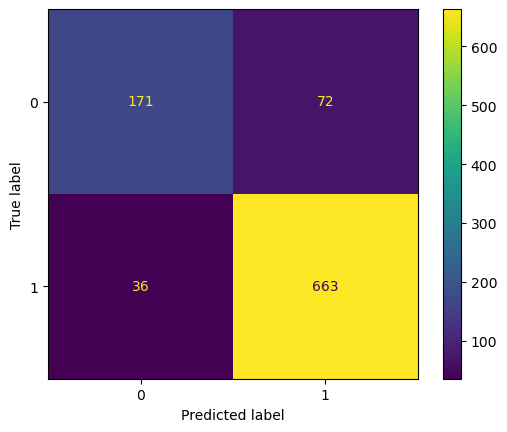

In [95]:
# Train Logistic Regression model on PneumoniaMNIST dataset
lr_model = LogisticRegression(max_iter=5000, random_state=42)

# Fit model
lr_model.fit(X_train_vec, y_train_m)

# Predict
y_pred_lr = lr_model.predict(X_test_vec)
y_proba_lr =lr_model.predict_proba(X_test_vec)[:, 1]

# Evaluate
print("Accuracy:", accuracy_score(y_test_m, y_pred_lr))
print(classification_report(y_test_m, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test_m, y_proba_lr))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_lr)
plt.show()

[0]	validation_0-logloss:0.52252
[10]	validation_0-logloss:0.31600
[20]	validation_0-logloss:0.25412
[30]	validation_0-logloss:0.23406
[40]	validation_0-logloss:0.22176
[50]	validation_0-logloss:0.21835
[60]	validation_0-logloss:0.21431
[70]	validation_0-logloss:0.21275
[80]	validation_0-logloss:0.21190
[90]	validation_0-logloss:0.20920
[100]	validation_0-logloss:0.20933
[110]	validation_0-logloss:0.20735
[120]	validation_0-logloss:0.20791
[130]	validation_0-logloss:0.20792
[136]	validation_0-logloss:0.20800
XGBoost Accuracy: 0.9065817409766455
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       243
           1       0.93      0.95      0.94       699

    accuracy                           0.91       942
   macro avg       0.88      0.87      0.88       942
weighted avg       0.91      0.91      0.91       942

XGBoost ROC AUC: 0.9683439599192263


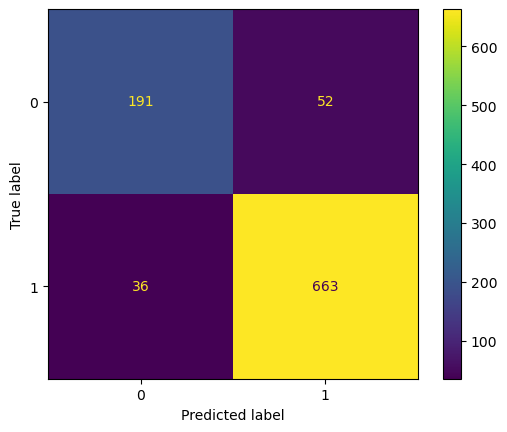

In [113]:
# Train XGBoost model on PneumoniaMNIST dataset without feature selection

xgb_model = XGBClassifier(
    n_estimators=300,        # number of trees (boosting rounds)
    learning_rate=0.1,       # step size shrinkage
    max_depth=5,             # maximum depth of trees
    subsample=0.8,           # fraction of training samples used per tree
    colsample_bytree=0.8,    # fraction of features used per tree
    random_state=42,
    use_label_encoder=False,
    early_stopping_rounds=20,
    eval_metric="logloss"
)

# Fit model 
xgb_model.fit(X_train_vec, y_train_m, eval_set=[(X_test_vec, y_test_m)], verbose=10)

# Predict
y_train_pred = xgb_model.predict(X_train_vec)
y_train_proba = xgb_model.predict_proba(X_train_vec)[:, 1] 

y_pred_xgb = xgb_model.predict(X_test_vec)
y_proba_xgb = xgb_model.predict_proba(X_test_vec)[:, 1]

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test_m, y_pred_xgb))
print(classification_report(y_test_m, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test_m, y_proba_xgb))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_xgb)
plt.show()

In [114]:
# Check if overfitting occurs

print("Train Accuracy:", accuracy_score(y_train_m, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test_m, y_pred_xgb))
print("Train ROC AUC:", roc_auc_score(y_train_m, y_train_proba))
print("Test ROC AUC:", roc_auc_score(y_test_m, y_proba_xgb))

Train Accuracy: 0.9946893255443441
Test Accuracy: 0.9065817409766455
Train ROC AUC: 0.9996145831989963
Test ROC AUC: 0.9683439599192263


In [115]:
## Feature Selection ##

In [116]:
# XGBoost Feature Importance 

selector = SelectFromModel(xgb_model, prefit=True)
X_vec_selected = selector.transform(X_train_vec)
X_test_vec_selected = selector.transform(X_test_vec)

In [117]:
selected_model = XGBClassifier(
    n_estimators=300,        # number of trees (boosting rounds)
    learning_rate=0.1,       # step size shrinkage
    max_depth=5,             # maximum depth of trees
    subsample=0.8,           # fraction of training samples used per tree
    colsample_bytree=0.8,    # fraction of features used per tree
    random_state=42,
    use_label_encoder=False,
    early_stopping_rounds=20,
    eval_metric="logloss"
)

selected_model.fit(X_vec_selected, y_train_m, eval_set=[(X_test_vec_selected, y_test_m)], verbose=10)

[0]	validation_0-logloss:0.52400
[10]	validation_0-logloss:0.31754
[20]	validation_0-logloss:0.26492
[30]	validation_0-logloss:0.24735
[40]	validation_0-logloss:0.23926
[50]	validation_0-logloss:0.23697
[60]	validation_0-logloss:0.23638
[70]	validation_0-logloss:0.23637
[80]	validation_0-logloss:0.23515
[90]	validation_0-logloss:0.23569
[99]	validation_0-logloss:0.23623


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Selected XGBoost Accuracy: 0.8949044585987261
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       243
           1       0.92      0.94      0.93       699

    accuracy                           0.89       942
   macro avg       0.87      0.86      0.86       942
weighted avg       0.89      0.89      0.89       942

Selected XGBoost ROC AUC: 0.9582884426311544


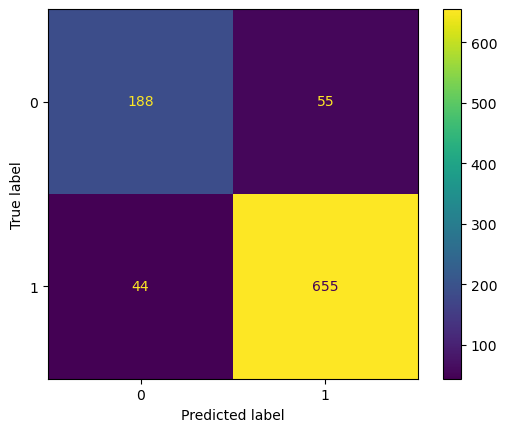

In [126]:
y_pred_selected = selected_model.predict(X_test_vec_selected)
y_proba_selected = selected_model.predict_proba(X_test_vec_selected)[:, 1]

print("Selected XGBoost Accuracy:", accuracy_score(y_test_m, y_pred_selected))
print(classification_report(y_test_m, y_pred_selected))
print("Selected XGBoost ROC AUC:", roc_auc_score(y_test_m, y_proba_selected))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_selected)
plt.show()


Top 20 Features by Gain:
   Feature       Gain
83     f92  53.585522
2       f2  36.781895
77     f86  33.579659
76     f85  24.309158
0       f0  19.903189
82     f91  14.393362
3       f3  13.552922
5       f5  12.241791
81     f90   9.894962
1       f1   7.942867
84     f93   7.712480
13     f13   7.332615
9       f9   7.022800
41     f41   6.616606
53     f62   6.423529
16     f16   6.358180
14     f14   6.312426
74     f83   6.279469
73     f82   6.185085
72     f81   5.923376


<Figure size 2000x600 with 0 Axes>

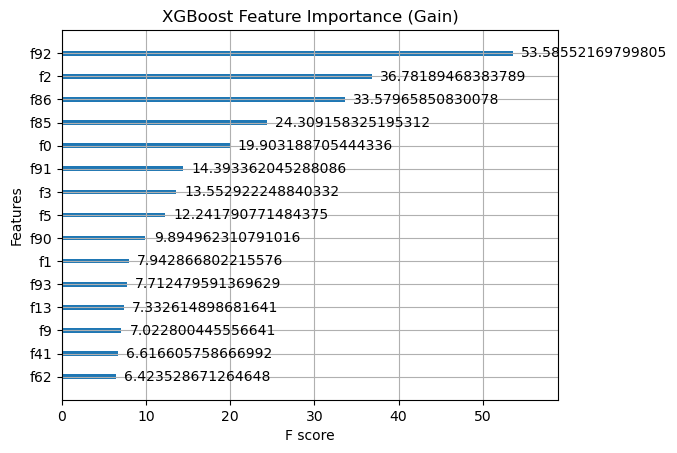

In [120]:
## 1. Feature Importance by Gain

# Get importance dictionary
importance_dict = xgb_model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame for better handling
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
}).sort_values(by="Gain", ascending=False)

print("\nTop 20 Features by Gain:")
print(importance_df.head(20))

# --- Plotting ---
plt.figure(figsize=(20, 6))
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=15)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

[0]	validation_0-logloss:0.52503
[10]	validation_0-logloss:0.32209
[20]	validation_0-logloss:0.26541
[30]	validation_0-logloss:0.24814
[40]	validation_0-logloss:0.23947
[50]	validation_0-logloss:0.23536
[60]	validation_0-logloss:0.23643
[70]	validation_0-logloss:0.23606
[80]	validation_0-logloss:0.23503
[90]	validation_0-logloss:0.23513
[97]	validation_0-logloss:0.23772
GAIN-XGBoost Model Accuracy: 0.8959660297239915
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       243
           1       0.92      0.94      0.93       699

    accuracy                           0.90       942
   macro avg       0.87      0.85      0.86       942
weighted avg       0.89      0.90      0.89       942

GAIN-XGBoost ROC AUC: 0.9576820501951642


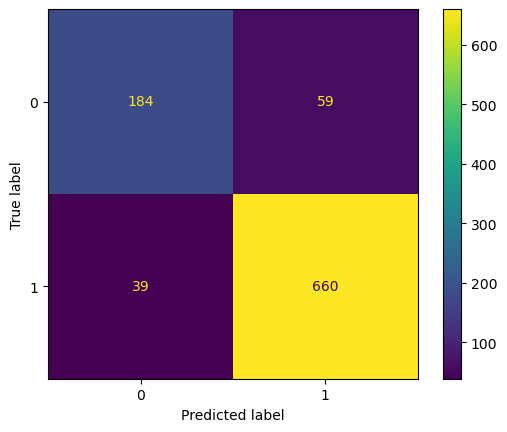

In [121]:
# Train XGBoost Model on the reduced data obtained by GAIN feature importance

top_features = importance_df['Feature'].head(20).tolist()
feature_names = [f"f{i}" for i in range(X_train_vec.shape[1])]

X_train_df = pd.DataFrame(X_train_vec, columns=feature_names)
X_test_df = pd.DataFrame(X_test_vec, columns=feature_names)


X_train_top = X_train_df[top_features]
X_test_top = X_test_df[top_features]


xgb_model_reduced_g = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    early_stopping_rounds=20
)

# Fit model
xgb_model_reduced_g.fit(X_train_top, y_train_m, eval_set=[(X_test_top, y_test_m)], verbose=10)

# Predict
y_train_pred = xgb_model_reduced_g.predict(X_train_top)
y_train_proba = xgb_model_reduced_g.predict_proba(X_train_top)[:, 1] 

y_pred_xgb = xgb_model_reduced_g.predict(X_test_top)
y_proba_xgb = xgb_model_reduced_g.predict_proba(X_test_top)[:, 1]

# Evaluate


print("GAIN-XGBoost Model Accuracy:", accuracy_score(y_test_m, y_pred_xgb))

print(classification_report(y_test_m, y_pred_xgb))

print("GAIN-XGBoost ROC AUC:", roc_auc_score(y_test_m, y_proba_xgb))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_xgb)
plt.show()

In [122]:
# train XGBoost ML on mixed top feature vectors 

for k in [10, 20, 30, 50]:
    top_features = importance_df['Feature'].head(k).tolist()
    X_train_top = X_train_df[top_features]
    X_test_top = X_test_df[top_features]

    xgb_model_reduced_g.fit(X_train_top, y_train_m, eval_set=[(X_test_top, y_test_m)], verbose=10)
    preds = xgb_model_reduced_g.predict(X_test_top)
    acc = accuracy_score(y_test_m, preds)
    print(f"Top {k} features → Accuracy: {acc:.4f}")

[0]	validation_0-logloss:0.52982
[10]	validation_0-logloss:0.35272
[20]	validation_0-logloss:0.31296
[30]	validation_0-logloss:0.30431
[40]	validation_0-logloss:0.30247
[50]	validation_0-logloss:0.30045
[60]	validation_0-logloss:0.30065
[70]	validation_0-logloss:0.29988
[74]	validation_0-logloss:0.30014
Top 10 features → Accuracy: 0.8800
[0]	validation_0-logloss:0.52503
[10]	validation_0-logloss:0.32209
[20]	validation_0-logloss:0.26541
[30]	validation_0-logloss:0.24814
[40]	validation_0-logloss:0.23947
[50]	validation_0-logloss:0.23536
[60]	validation_0-logloss:0.23643
[70]	validation_0-logloss:0.23606
[80]	validation_0-logloss:0.23503
[90]	validation_0-logloss:0.23513
[97]	validation_0-logloss:0.23772
Top 20 features → Accuracy: 0.8960
[0]	validation_0-logloss:0.52334
[10]	validation_0-logloss:0.32246
[20]	validation_0-logloss:0.26461
[30]	validation_0-logloss:0.24609
[40]	validation_0-logloss:0.24074
[50]	validation_0-logloss:0.23788
[60]	validation_0-logloss:0.23682
[70]	validation

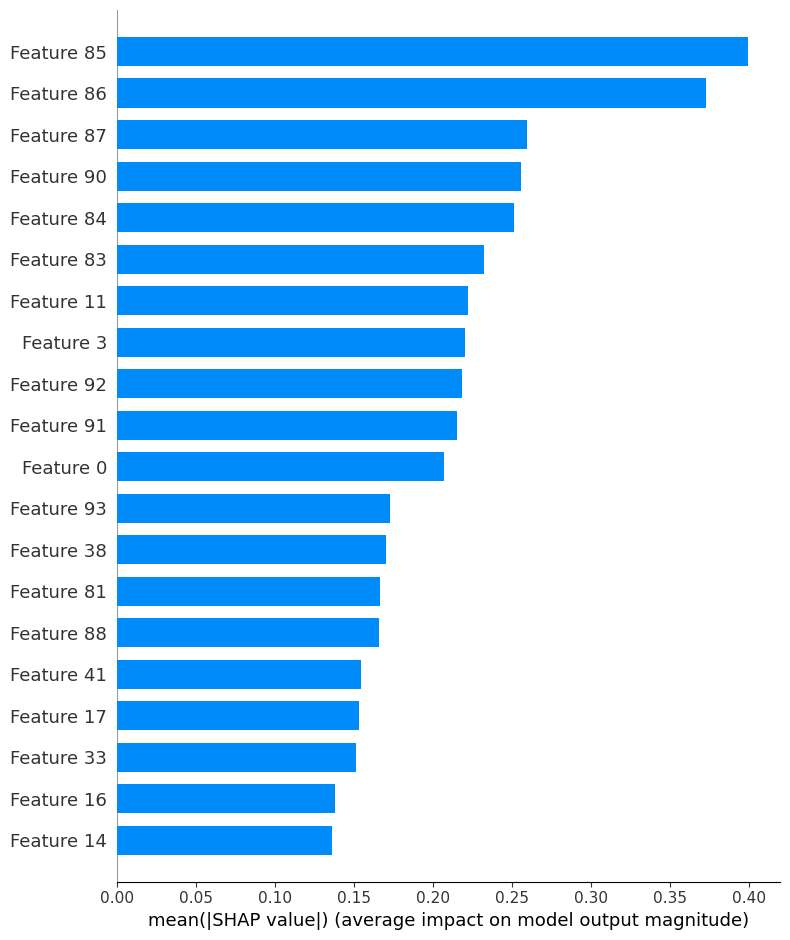

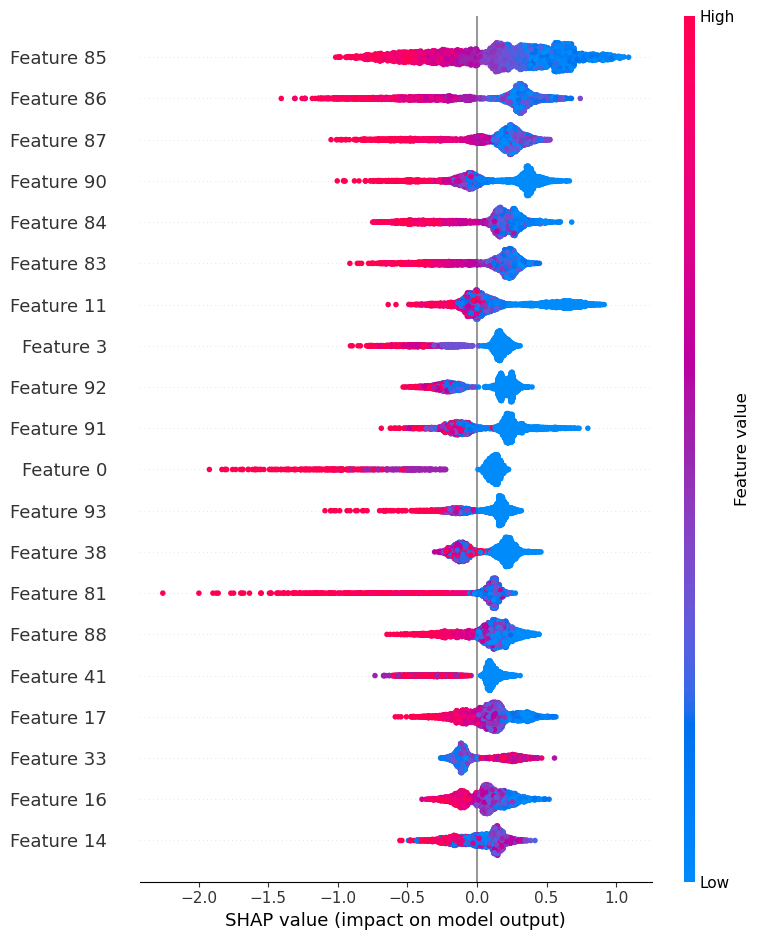

In [123]:
## 2. Try more feature Importance with SHAP

# Get the feature importance scores, shap values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_vec)

shap.summary_plot(shap_values, X_train_vec, plot_type="bar")
shap.summary_plot(shap_values, X_train_vec)

[0]	validation_0-logloss:0.52104
[10]	validation_0-logloss:0.31566
[20]	validation_0-logloss:0.25471
[30]	validation_0-logloss:0.23427
[40]	validation_0-logloss:0.22533
[50]	validation_0-logloss:0.21972
[60]	validation_0-logloss:0.21830
[70]	validation_0-logloss:0.21734
[80]	validation_0-logloss:0.21510
[90]	validation_0-logloss:0.21474
[100]	validation_0-logloss:0.21516
[110]	validation_0-logloss:0.21503
[111]	validation_0-logloss:0.21503
Reduced XGBoost Model Accuracy: 0.910828025477707
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       243
           1       0.93      0.95      0.94       699

    accuracy                           0.91       942
   macro avg       0.89      0.87      0.88       942
weighted avg       0.91      0.91      0.91       942

Reduced XGBoost ROC AUC: 0.9650529563103082


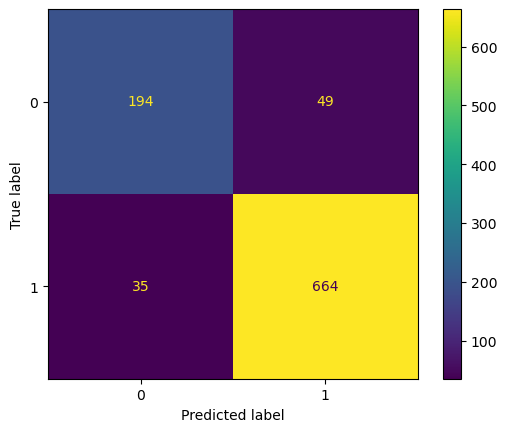

In [124]:
#Select top features with respect to shap values
feature_importances = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(feature_importances)[-50:]

# Reduce original feature vec of each training and test image 
X_train_reduced = X_train_vec[:, top_features_idx]
X_test_reduced  = X_test_vec[:, top_features_idx]

# Train a new XGBoost Model on the reduced data obtained by SHAP feature importance 
xgb_model_reduced_s = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    early_stopping_rounds=20
)
xgb_model_reduced_s.fit(X_train_reduced, y_train_m, eval_set=[(X_test_reduced, y_test_m)], verbose=10)

# Predict
y_train_pred = xgb_model_reduced_s.predict(X_train_reduced)
y_train_proba = xgb_model_reduced_s.predict_proba(X_train_reduced)[:, 1] 

y_pred_xgb = xgb_model_reduced_s.predict(X_test_reduced)
y_proba_xgb = xgb_model_reduced_s.predict_proba(X_test_reduced)[:, 1]

# Evaluate


print("Reduced XGBoost Model Accuracy:", accuracy_score(y_test_m, y_pred_xgb))

print(classification_report(y_test_m, y_pred_xgb))

print("Reduced XGBoost ROC AUC:", roc_auc_score(y_test_m, y_proba_xgb))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_xgb)
plt.show()




In [125]:
# Check if overfitting occurs

print("Train Accuracy:", accuracy_score(y_train_m, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test_m, y_pred_xgb))
print("Train ROC AUC:", roc_auc_score(y_train_m, y_train_proba))
print("Test ROC AUC:", roc_auc_score(y_test_m, y_proba_xgb))

Train Accuracy: 0.9790228359001594
Test Accuracy: 0.910828025477707
Train ROC AUC: 0.9966616862169277
Test ROC AUC: 0.9650529563103082
